Epoch 1/50


721/721 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1653.0992 - mae: 32.1176 - val_loss: 895.3793 - val_mae: 24.7933
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 934.0648 - mae: 25.1595 - val_loss: 896.0843 - val_mae: 24.8872
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 942.8570 - mae: 25.3789 - val_loss: 896.1188 - val_mae: 24.7306
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 930.9828 - mae: 25.0746 - val_loss: 895.7438 - val_mae: 24.8609
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 952.7094 - mae: 25.5086 - val_loss: 895.5230 - val_mae: 24.7741
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 926.3516 - mae: 25.0916 - val_loss: 895.5272 - val_mae: 24.7610
Epoch 7/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 940.9567 - mae: 25.3093 - val_loss: 863.6716 - val_mae: 24.4325
Epoch 8/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 907.6910 - mae: 24.7902 - val_loss: 857.2829 - val_mae: 24.1102
Epoch 9/50
721/721

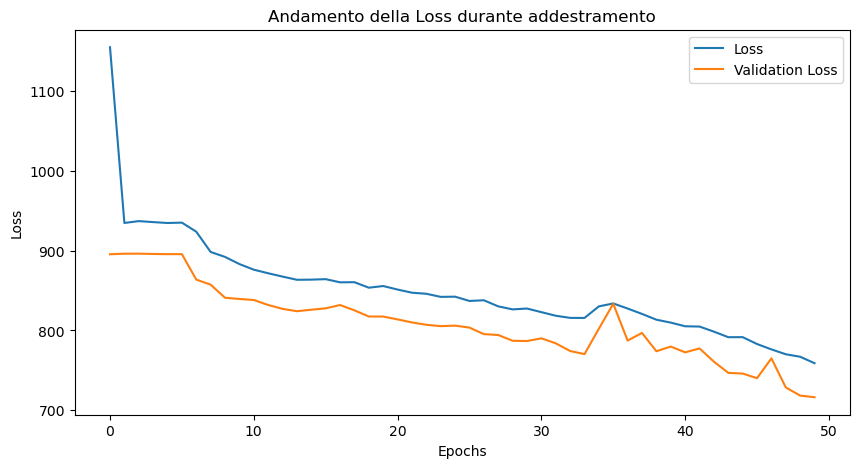

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from meteostat import Daily, Point
from datetime import datetime

# Percorso del file con i ritardi consistenti
file_ritardi = "C:/Users/C.Marino/Desktop/dataset/ritardi_consistenti.txt"

# Carica il dataset con i ritardi
df = pd.read_csv(file_ritardi, sep=",")

# Converte la colonna delay in timedelta
df['delay'] = pd.to_timedelta(df['delay'])

# Crea una colonna per i ritardi in minuti
df['delay_minutes'] = df['delay'].dt.total_seconds() / 60

# Rimuove i valori NaN e fuori scala
df = df.dropna(subset=['delay_minutes'])
df = df[df['delay_minutes'].between(-15, 120)]  # Filtra ritardi tra -15 e 120 minuti

# Converte le date e le ore in formato corretto
df['arrival_date'] = pd.to_datetime(df['arrival_date'], errors='coerce')
df['hour'] = pd.to_datetime(df['arrival_time_x'], errors='coerce').dt.hour
df['day_of_week'] = df['arrival_date'].dt.dayofweek  # 0 = Lunedì, ..., 6 = Domenica

# 📌 **Aggiunta dati meteo**
start = datetime(2025, 2, 10)
end = datetime(2025, 2, 14)
rome = Point(41.9028, 12.4964)
weather = Daily(rome, start, end)
weather = weather.fetch()

# Reset index per unire i dati meteo con il dataset dei ritardi
weather = weather.reset_index()
weather['time'] = pd.to_datetime(weather['time'])
weather = weather[['time', 'tavg', 'prcp', 'wspd']]  # tavg = temperatura media, prcp = precipitazioni, wspd = velocità del vento
weather.rename(columns={'time': 'arrival_date'}, inplace=True)

# Merge tra dati ritardi e dati meteo
df = df.merge(weather, on='arrival_date', how='left')

# 📌 **Sostituisci eventuali valori mancanti nei dati meteo con la media**
df['tavg'].fillna(df['tavg'].mean(), inplace=True)
df['prcp'].fillna(0, inplace=True)  # Se pioggia non è riportata, assumiamo 0
df['wspd'].fillna(df['wspd'].mean(), inplace=True)

# 📌 **Selezione delle colonne utili per il modello**
features = ['route_id', 'stop_id', 'day_of_week', 'hour', 'shape_dist_traveled', 'tavg', 'prcp', 'wspd']
target = 'delay_minutes'

df_model = df[features + [target]].dropna()

# 📌 **Encoding delle variabili categoriche**
label_encoders = {}
for col in ['route_id', 'stop_id']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# 📌 **Normalizzazione dei dati**
scaler = StandardScaler()
df_model[features] = scaler.fit_transform(df_model[features])

# 📌 **Suddivisione in Training e Test**
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model[target], test_size=0.2, random_state=42)

# 📌 **Reshape dei dati per LSTM**
X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# 📌 **Creazione del modello LSTM**
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# 📌 **Compilazione del modello**
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 📌 **Addestramento del modello**
epochs = 50
batch_size = 32
history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_reshaped, y_test), verbose=1)

# 📌 **Valutazione del modello**
loss, mae = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Loss: {loss}, MAE: {mae}")

# 📊 **Visualizzazione della perdita durante l'addestramento**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Andamento della Loss durante addestramento')
plt.show()
